# Percolation

The goal of this notebook is to implement the spread of the Covid19 pandemic using percolation.

In [1]:
import collections
import random
import time
from typing import Union

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# import a helper function from the utils module
from utils import get_neighbors

# use the searborn style
plt.style.use("seaborn")
# make interactive plots
plt.ion()

# %matplotlib qt

In a first step, the problem is defined:

- define the number of grid points **nx** and **ny**
- define the distance between the node, herein, social distancing can be modeled
- define the x and y coordinates and create a meshgrid
- define the active nodes as a set
    - this is done as a set because each element in a set is unique
- randomly choose one single patient zero from the nodes, as the spread starts with one single person

In [2]:
# define the number of points in x and y direction
nx, ny = 30, 30
# define the offset
offset = 1
# define the distance between the nodes
distance = 1
# define the x and y coordinates
x_coord = np.arange(start=offset, stop=nx + offset, step=distance, dtype=float)
y_coord = np.arange(start=offset, stop=ny + offset, step=distance, dtype=float)
# define the x and y limits
xlim, ylim =  (x_coord[0], x_coord[-1]), (y_coord[0], y_coord[-1])
# create a mesh
x, y = np.meshgrid(x_coord, y_coord)
# create an array containing the coordinates of each point and the corresponding indices as array
coords = np.array(list(zip(x.flatten(), y.flatten())), dtype=float)
idcs = np.arange(0, coords.shape[0])
# define the search tree as set from which each element which is visited will be removed
tree = {(x, y) for x, y in coords}
# select random coordinates which represent the infected persons
rng = np.random.default_rng()
num_infected = 1
idx = rng.choice(idcs, size=num_infected)
# get a random coordinate which represents the patient zero
pat_zero = [(x, y) for x, y in coords[idx, ...]]

Next, the probability of infection given the distance and the eposure time has to be determined, i.e.
$$ P(\text{infection}|\text{distance, exposure time}) $$
This is rather comlicated.

In [3]:
# define the probability of infection
# TODO: Add function for proability based on distance and exposure time
def prob_infection(distance, exposure_time):
    pass
p_infect = 0.5

In [4]:
# define the color black with a hex string
black = "#000000"
red = "#ff0000"
orange = "#e69500"
blue = "#0000ff"
green = "#006200"
# define the figure
nrows, ncols = 1, 1
fig1 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows, ncols, figure=fig1)
ax1 = fig1.add_subplot(gs[0, 0])
# plot the grid
ax1.plot(x, y, color=black)
ax1.plot(y, x, color=black)
for x, y in pat_zero:
    ax1.plot(x, y, marker='o', ms=10, color=blue, ls="");
blue_patch = mpatches.Patch(color=blue, label="pat. zero")
ax1.legend(handles=[blue_patch]);
# prevent the plot from showing as this is shown below
plt.close()

The pseudo code algorithm of the percolation can be seen below:

    START Percolation
    
    INIT frontier with patient zero
    INIT tree with patients
    
    WHILE frontier not empty

        INIT node <- frontier.pop
        tree.remove(node)
        INIT neighbors <- get_neighbors
        INIT infected neighbors <- SUBSET neighbors
        FOR x, y in infected neighbors
            IF x, y not in tree OR x, y in frontier
                CONTINUE
            ENDIF
            frontier.append(x, y)

Notice that a deque is used instead of a list, which is because a deque has appending and pop costs of $\mathcal{O}(1)$.
In contrast, lists have appending costs of $\mathcal{O}(n)$.
See [the official python documentation](https://docs.python.org/3/library/collections.html#collections.deque).

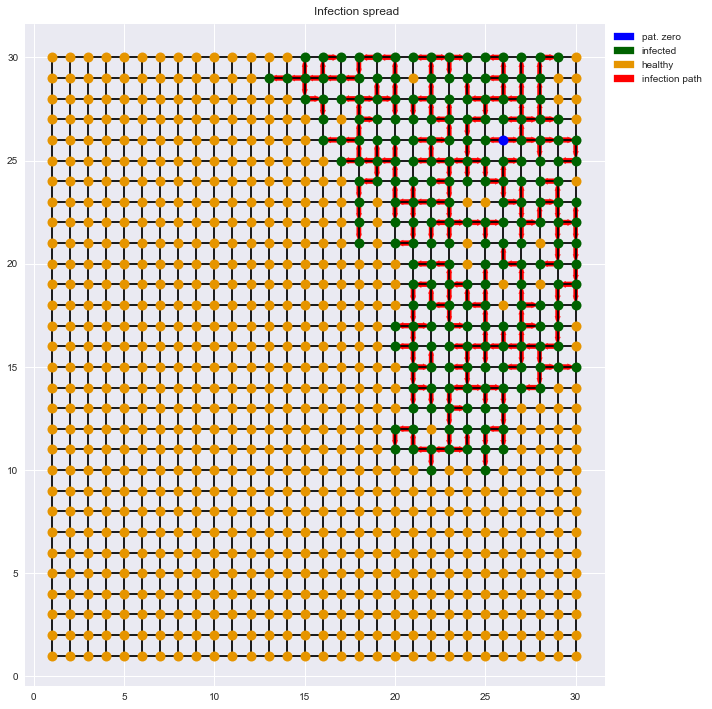

In [5]:
# save the states in a dictionary
tree_struct = {}
# define the frontier as queue
frontier = collections.deque(pat_zero)
while frontier:
    infected = []
    node = frontier.pop()
    tree.remove(node)
    neighbors = get_neighbors(node, distance, x_limit=xlim, y_limit=ylim)
    mask = rng.random(size=neighbors.shape[0]) < p_infect
    for x, y in neighbors[mask]: 
        if (x, y) not in tree or (x, y) in frontier:
            continue
        frontier.append((x, y))
        infected.append((x, y))
        # modify the plot
        ax1.arrow(node[0], node[1], x - node[0], y - node[1], width=1 / 125 * min(nx, ny), length_includes_head=True, head_width=1 / 100 * min(nx, ny), color=red)
        ax1.plot(x, y, marker="o", ms=10, color=green)
    tree_struct[f"Node: {node}"] = infected

# modify the plot
for x, y in tree:
    ax1.plot(x, y, marker="o", ms=10, color=orange)
green_patch =  mpatches.Patch(color=green, label="infected")
red_patch =  mpatches.Patch(color=red, label="infection path")
orange_patch = mpatches.Patch(color=orange, label="healthy")
ax1.legend(handles=[blue_patch, green_patch, orange_patch, red_patch], bbox_to_anchor=(1, 1), loc="upper left")
fig1.suptitle(f"Infection spread")
fig1.tight_layout()
fig1